# Working with shapes

Shapes are object created using the package `Shapely` which know about their geometry. They don't need to be associated with a map in any way. We will start with basic shapes, and then use shapes on a map, since shape functions have been included in `cartopy`.

In [154]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import shapely.geometry
import shapely.ops
import cartopy
import cartopy.io.shapereader as shpreader

### 0D shapes: Points

In [155]:
point = shapely.geometry.Point(0.2, 1.0)

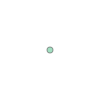

In [156]:
# Notice, the ipython '__repr__' (representation) displays the point as the output
point

In [160]:
# See some of the point attributes
print(point.geom_type)
print(point.area)
print(point.length)
print(point.bounds)
print(point.coords)   # explore this object...
print(point.coords[:])

Point
0.0
0.0
(0.2, 1.0, 0.2, 1.0)
[(0.2, 1.0)]


In [161]:
# A collection of random points...
point1 = shapely.geometry.Point(0.2, 1.0)
point2 = shapely.geometry.Point(0.1, 0.2)
point3 = shapely.geometry.Point(0.5, 0.0)
point4 = shapely.geometry.Point(0.8, 0.5)

In [162]:
# We can see the distance of the points from one another
point2.distance(point1)

0.806225774829855

### 1D shapes: Lines and Rings

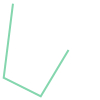

In [163]:
# An ordered sequence of points is a `LineString'
line = shapely.geometry.LineString((point1, point2, point3, point4))
line

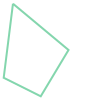

In [164]:
# To make a closed shape, use a `LinearRing'
closed_line = shapely.geometry.LinearRing(line)
closed_line

In [165]:
# Some of the attributes of the LinearRing..
print(closed_line.area)   # no area since it is not 'filled'
print(closed_line.length) # the perimeter of the shape
print(closed_line.bounds) # an xy-plane bounding box

0.0
2.6175595274050085
(0.1, 0.0, 0.8, 1.0)


### 2D shapes, Polygons and Buffers

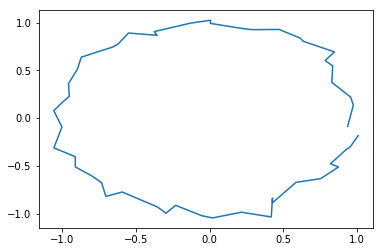

In [166]:
# Let's make a circle, with some noise

N = 50

x = np.cos(np.linspace(0, 2.0*np.pi, N+1))[:-1] + 0.05*np.random.randn(50)
y = np.sin(np.linspace(0, 2.0*np.pi, N+1))[:-1] + 0.05*np.random.randn(50)

plt.plot(x, y, '-')


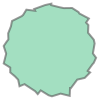

In [167]:
xy = zip(x, y)
poly = shapely.geometry.Polygon(xy)
poly

3.1555867451564796
POINT (-0.02425293744429447 0.003143917124500849)
False True


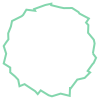

In [168]:
# Some of the Polygon attributes
print(poly.area)  # does this make sense?
print(poly.centroid)
print(poly.contains(point1), poly.contains(point2))
poly.boundary

We can also create 2D objects by adding buffers to existing 0D and 1D objects

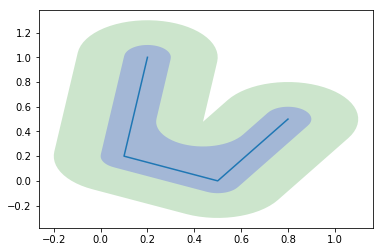

In [173]:
dialated = line.buffer(0.3)
eroded = dialated.buffer(-0.2)

plt.plot(*line.xy)
plt.fill(*dialated.boundary.xy, 'g', alpha=0.2)
plt.fill(*eroded.boundary.xy, 'b', alpha=0.2)

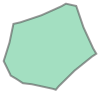

In [174]:
poly.buffer(-.8)

### Operations

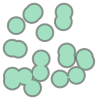

In [175]:
# First, let's make a collection of fat points.
xy = np.random.rand(20, 2)
points = shapely.geometry.MultiPoint(xy).buffer(0.1)
points

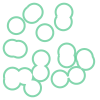

In [176]:
points.boundary

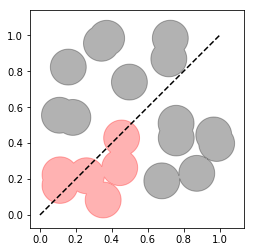

In [194]:
# make a new line
line2 = shapely.geometry.LineString([(0, 0), (1, 1)])

# loop over the polygons in the regions and plot, colored 
# differently if they intersect line1
for poly in points.boundary:
    if poly.intersects(line2):
        color = 'r'
    else:
        color = 'k'
    coords = poly.coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color, alpha=0.3)

# Plot the line also
x, y = zip(*line2.coords[:])
plt.plot(x, y, '--k')
plt.gca().set_aspect(1.0)

# Shapes on Maps!

## Reading your own shapes and using `cartopy`

You can read in shapefiles outside of the Natural Earth dataset and use them on maps with `cartopy`. Here we look at shipping lanes in the northwest Gulf of Mexico. You can get to the shapes or polygons themselves two different ways using `cartopy`. The first uses the `feature` interface that we've been using (with `add_feature`), but limits our ability to access attributes of the files. The second gives more access.


### 1st approach for using a generic shapefile:

We start with a map:

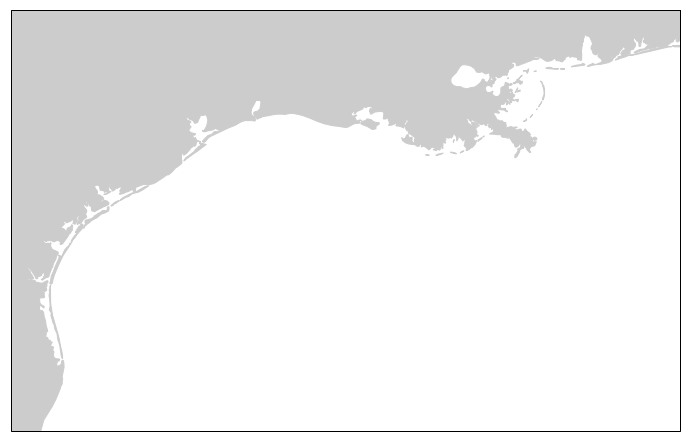

In [195]:
proj = cartopy.crs.LambertConformal()
pc = cartopy.crs.PlateCarree()
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([-98, -87, 25, 31], pc)
ax.add_feature(land_10m, facecolor='0.8')

We then set up to read in shipping lane data, which is in the `data` directory:

In [196]:
fname = '../data/fairway/fairway.shp'

shipping_lanes = cartopy.feature.ShapelyFeature(shpreader.Reader(fname).geometries(),
                                cartopy.crs.PlateCarree(), facecolor='none')

Now we can just add the shipping lanes onto our map!

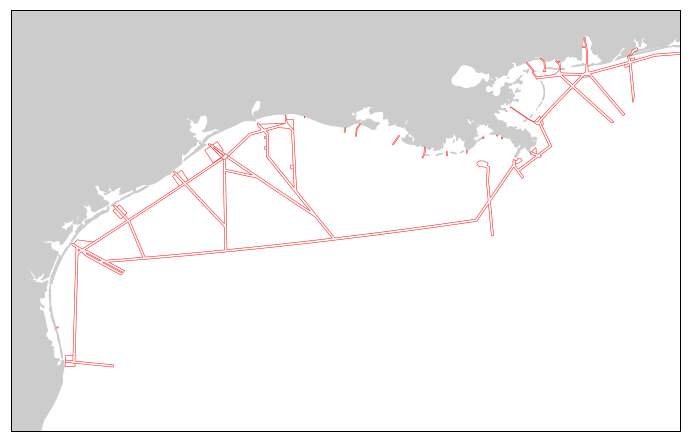

In [197]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([-98, -87, 25, 31], cartopy.crs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')

# shipping lanes
ax.add_feature(shipping_lanes, edgecolor='r', linewidth=0.5)

### 2nd approach for using a generic shapefile

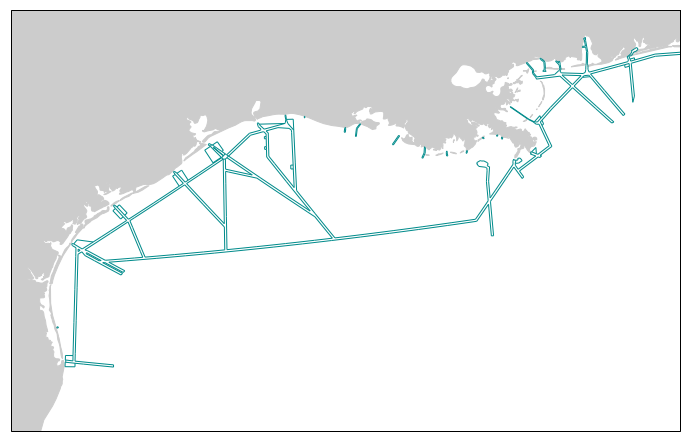

In [198]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([-98, -87, 25, 31], cartopy.crs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')

fname = '../data/fairway/fairway.shp'
ax.add_geometries(cartopy.io.shapereader.Reader(fname).geometries(),
                  pc, edgecolor='darkcyan')


## Working with shapefile geometries and attributes

In addition to plotting shapes from shapefiles, we can do some simple methods to convert between projections and to check properties of the shapes.

Consider the following: 

What states do you travel over when you fly from LA (airport code LAX) to NYC (airport code EWR)?

    LAX: 33.9425° N, 118.4081° W
    EWR: 40.6925° N, 74.1686° W

We will begin by looking at a map of states and the start and end points.

In [199]:
# set up our two end points
lon_lax, lat_lax = -118.4081, 33.9425
lon_ewr, lat_ewr = -74.1686, 40.6925

# set up projection
merc = cartopy.crs.Mercator()
pc = cartopy.crs.PlateCarree()

### Great Circle Distance

How do you find an airplane's flight path? The shortest line between two places on earth is not necessarily a straight line in the projection you are using. The shortest distance is called the Great Circle distance and it is the shortest distance between two places on a sphere. 

For example, here is the shortest path between Boston and Tokyo. It is a straight line in this rather globe-like projection because it preserves this property.

![greatcircle](http://web.mit.edu/dsheehan/www/MapsAPIexamples/worldfromspaceBosNrt.jpg)

However, [this link](http://web.mit.edu/dsheehan/www/MapsAPIexamples/gcr.html) shows the flight path in a different projection. Not so straight anymore.

An easy way to get the Great Circle distance is from the [`proj.4`](http://proj4.org/) library, or its python wrapper, [`pyproj`](https://jswhit.github.io/pyproj/). A nice thing about `cartopy` is it's easy to export from a `cartopy` projection to set up a `pyproj` projection.

In [150]:
## Get points between the two end points along the great circle distance ##
import pyproj

# here we use the projection we already initiated (proj) to initiate one in the package pyproj
# which connects to the Geodesic, which is the Earth as an approximate sphere
g = pyproj.Geod(merc.proj4_init)

# once we have this geodesic, we can calculate 100 points along the great circle connecting the end points
pathll = g.npts(lon_lax, lat_lax, lon_ewr, lat_ewr, 100)

# we make our flight path using the points from the Geodesic
flight_path = shapely.geometry.LineString(pathll)


Now that we have the flight path, let's look at it on a map. You can see the curve of the earth compared with this projection.

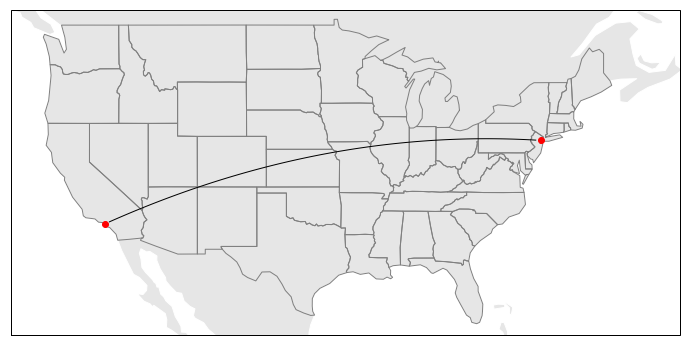

In [200]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=merc)
ax.set_extent([-128, -60, 24, 50], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')
ax.add_feature(cartopy.feature.OCEAN, facecolor='w')

# add states
# can plot states like this, but doesn't allow access to metadata
shapename = 'admin_1_states_provinces_lakes_shp'
states = cartopy.feature.NaturalEarthFeature(category='cultural', scale='110m', facecolor='none', name=shapename)
ax.add_feature(states, edgecolor='gray')

# add end points
ax.plot([lon_lax, lon_ewr], [lat_lax, lat_ewr], 'ro', transform=pc)

# add the flight path as a shape
ax.add_geometries([flight_path], pc, facecolor='none', edgecolor='k')


### So what states are flown over?

We can see the states that the plane would fly over, but how do we get the names of the states? The way we read in the states before – with `add_feature` – allowed us to plot them but not to access any of the attributes of the objects.

Instead, we will use a shape reader that is built into `cartopy`. When we read in the files at this level, we can access both the geometry and attributes.

['Arizona', 'California', 'Colorado', 'Nevada', 'New Mexico', 'Kansas', 'Missouri', 'Illinois', 'Indiana', 'Ohio', 'New Jersey', 'Pennsylvania']


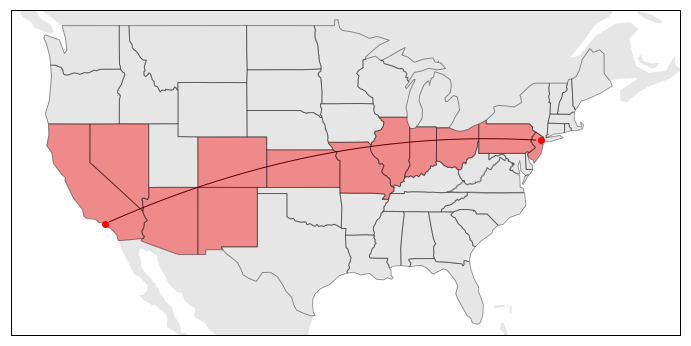

In [201]:
# Set up reader for this file
states_shp = shpreader.natural_earth(category='cultural', resolution='110m', name=shapename)
reader = shpreader.Reader(states_shp)

# Read in the data from the file into the "states" generator which we can iterate over
states = reader.records()

# Note that if we didn't re-read this each time this cell was run, we could only run it once.
# Once the states have been iterated over, the pointer is at the end of them and there are
# none left to show. This is like reading all of the lines of a file and reaching the end.

# Remake map here
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=merc)
ax.set_extent([-128, -60, 24, 50], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')
ax.add_feature(cartopy.feature.OCEAN, facecolor='w')

# add end points
ax.plot([lon_lax, lon_ewr], [lat_lax, lat_ewr], 'ro', transform=pc)

# add the flight path as a shape
ax.add_geometries([flight_path], pc, facecolor='none', edgecolor='k')

# Loop through states and see if they intersect flight path
# deal with shapes differently if want to dig into them more

visible_states = []  # initialize for storing states

for state in states:
    # pick a default color for the land with a black outline,
    # this will change if the flight intersects with a state
    facecolor = '0.9'
    edgecolor = 'black'

    if state.geometry.intersects(flight_path):
        facecolor = 'red'
        # also save to list if intersects
        visible_states.append(state.attributes['name'])

    ax.add_geometries([state.geometry], pc,
                      facecolor=facecolor, edgecolor=edgecolor, alpha=0.4)

print(visible_states)

---
### *Exercise*

> _What additional states could a passenger in this airplane see? Assume he or she can see 100km from the airplane's position, on either side of the plane._

> Make a buffer away from the flight path.
>  * What should the units of the projection be? 
>  * First you will need to convert projections. 
>  * _What is a good choice for a projection and why?_
>  * Once you set up your buffer, add it to the map.

---

#### Transforming geometry between projections

Here we take the last state from running our loop and change it's projection from PlateCarree (`pc`) to Mercator (`merc`):

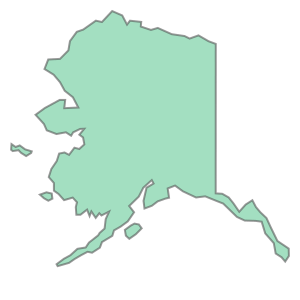

In [99]:
merc.project_geometry(state.geometry, pc)

---
### *Exercise (continued)*

> _What additional states could a passenger in this airplane see? Assume he or she can see 100km from the airplane's position, on either side of the plane._

> 
> What states are visible?
>  * Save the names of the visible states and print them out 
>  * Color differently on the map the states that are visible from the plane but that aren't actually flown over.

---

---
### *Exercise (continued)*

> Find the length of the flight track and area of the flight buffer region.

> 
> What projection should we use to get a good approximation of the real values?
>  * Compare your length with the actual distance
>  * Compare your buffer region with an appropriate estimation

---